# ResNet50

In this notebook, I'm using transfer learning with the ResNet50 network to compare its performance to CNN1 and VGG16.

## 1.1 Google Colab Setup - When running locally, skip ahead to Local Setup

I ran this notebook in Google Colab Pro in the Python3 environment using a GPU runtime.

At the time of writing, it was necessary to update the `tensorflow_datasets` package to import the dataset correctly. After running this cell, restart the runtime so that the new version of this package is loaded.

In [ ]:
!pip install tensorflow_datasets==4.2.0

The following cells have been adapted from code located [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228)

Ensure we're connected to a GPU

In [ ]:
from tensorflow.test import gpu_device_name

device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mount Google Drive and authenticate by following the instructions in the cell output

In [ ]:
from google.colab import drive 

# Default location for the drive
ROOT = "/content/drive"  

# Mount Google Drive at /content/drive
drive.mount(ROOT)           

Change to the directory containing project files

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/BrainStation Capstone Project/capstone'

%cd '{PROJECT_PATH}'

This cell imports `pcamlib.py` into Google Colab

In [ ]:
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

For best performance, upload the `tensorflow_datasets` folder created by running the CLI command `tfds build patch_camelyon` locally to the folder specified in `pcam_path` within your Google Drive. 

If you have not done this step, running this cell will instead download the dataset automatically and save it to the virtual disk in Google Colab. When not using Colab Pro, I have found that I quickly ran out of disk space with this method. Note that this step can take 10-20 minutes while the files are downloaded and processed. If you have uploaded the dataset already, this cell should run almost instantly, and print the information about the dataset in the `tfds.core.DatasetInfo()` object.

In [ ]:
pcam_path = '/content/drive/MyDrive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = pcamlib.load_pcam(data_dir=pcam_path)

---

## 1.2 Local Setup - Skip these cells when running in Google Colab

In [2]:
# pcamlib.py is my library of helper functions
import pcamlib

This cell should automatically download the `patch_camelyon` dataset into `~/tensorflow_datasets/patch_camelyon` if it's not already installed (7.48 GB). If there are any issues, run the CLI command `tfds build patch_camelyon` first to install. If the dataset already exists in this location, this cell should print the dataset info almost instantly. If you selected a different location to install the dataset, update the `data_dir` parameter with the location of the dataset you selected.

In [3]:
# Load dataset and dataset info 
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits=

----

## 1.3 Finish Setup - Always run these cells

In [4]:
# Import datascience packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import tensorflow packages
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

By default, the batch size for the training set is 64, and 128 for the test and validation sets.

In [5]:
# Create generator "pipelines" for train, validation and test sets.
# Default batch sizes of 64 for the train set and 128 for validation and test sets to speed up calculations
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## 2.0 Training the Model

> If you are not training this model and are loading it from a file, skip ahead to section 2.2 Loading the Model

Just like with VGG16, we create an instance of the ResNet50 network with the pretrained weights from the ImageNet dataset. It's important to set `include_top=False` so that we can strip off the Dense layers which are configured for a specified image size. `input_shape` in this case is configured to accommodate the 96x96 px, 3-channel RGB images in the PCam dataset.

In [6]:
resnet50 = ResNet50V2(weights='imagenet', 
                      include_top=False, 
                      input_shape=(96,96,3))

Next, we freeze the pre-trained layers so that they aren't changed during the training process.

In [7]:
# Freeze all the layers in the base model
for layer in resnet50.layers:
    layer.trainable = False
    
resnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

At this point, we have over 23.5 million parameters in the model, but none of them need to be trained. Like with VGG16, the size of this network will still be relevant because it takes time for the images to be propagated through all of these layers.

We flatten the output of the final layer into a 1D array, and add a couple of Dense layers with 25% Dropout which will be trainable so that the model can learn how to identify the different classes in our PCam data. Then we add a final Dense layer with 2 outputs which will make the final class predictions for us. 

In [8]:
# Add our own layers to the end of the network
x = resnet50.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

resnet50 = Model(inputs=resnet50.input, 
              outputs=output)

In [9]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

After adding these trainable layers, we finish at around 28.3 million parameters with over 4.7 million trainable parameters. This portion of the network alone has over 3 times as many parameters as the entire CNN1 network!

We compile the model with the `Adam` optimizer as it is one of the most commonly used and most effective optimizers when using CNNs for image classification. We use a `categorical_crossentopy` loss function and track the accuracy of the train and validation set throughout the training process.

In [13]:
resnet50.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we create an early stopping callback function which will stop the training process early if the validation loss fails to decrease over the specified number of epochs. This allows us to set the number of training epochs to a large number without fear of wasting time going through all the epochs if they aren't improving the results.

I experimented with different values for the patience, and 8 may be slightly too long for optimal results, but I wanted to see if the networks would improve at all if left to train for a longer period of time. 

In [14]:
# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           mode='min', 
                           verbose=1)

This cell trains the model, and it's important to save the output into a variable called `history` so the training accuracy and loss history can be plotted later. I selected 30 epochs as an arbitrarily large number, and rely on the early stopping threshold to determine how long the model is trained. 

`steps_per_epoch` is simply the size of the training set divided by the batch size (262144 / 64) which ensures the entire training set is covered in each epoch.

Similarly, `validation_steps` is the size of the validation set divided by the batch size of the validation set (32768 / 128) to ensure the entire validation set is tested.

If changing the batch size, it's important to update these variables accordingly.

In [ ]:
%%time
history = resnet50.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Here, I save the history as a pandas dataframe for easier exporting to .csv and plotting.

In [22]:
# Save the history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

---

## 2.1 Saving the Model

Because the training process can take a long time, it's a good idea to save the trained model, the training history, and the model predictions to external files. 

In [ ]:
# Save the fitted model to a file
resnet50.save('data/models/resnet50')

In [23]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/resnet50_history.csv')

In general, I leave `save=False` when running these cells to avoid accidentally overwriting files. Simply change this to `save=True`, and consider changing the filepath, when you want to save these results.

On average, calculating `y_proba` takes around 40 seconds in Colab.

In [ ]:
%%time
y_proba = pcamlib.generate_y_proba(resnet50, test_pipeline, class_1=False, save=False, filepath='data/models/y_proba/resnet50_y_proba.csv')

---

## 2.2 Loading the Model

Here, you can load the model, it's history, and predictions from files by running these cells.

In [6]:
# Load the model from a file
resnet50 = load_model("data/models/resnet50")

In [7]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/resnet50_history.csv')

In [8]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/models/y_proba/resnet50_y_proba.csv')

This cell extracts the ground truth labels from the test set and saves them as `y_true`

In [9]:
%%time

# Create a list of the true labels for the test set
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 25.3 s, sys: 2.26 s, total: 27.6 s
Wall time: 5.8 s


---

## 3.0 Evaluating the Model

I am evaluating the outputs from a trained model I've loaded from section 2.2 above.

If you trained a model in this notebook, the results will likely be very different from what I'm describing in the markdown cells.

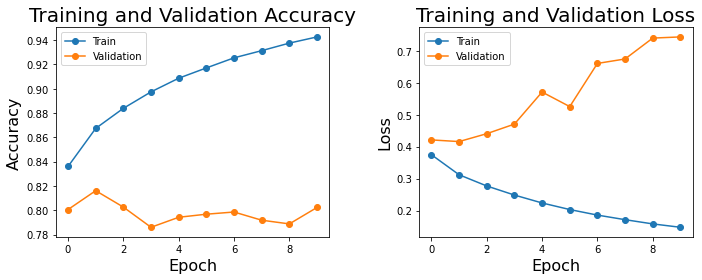

In [20]:
pcamlib.plot_history(hist_df, save=True, filepath='data/plots/resnet50_acc_loss.png')

The training stopped after 9 epochs, and there is an extremem amount of overfitting happening with this network. Again, this could be compensated for in the future by increasing the level of dropout between the trainable dense layers at the end of the network.

This cell makes predictions based on `y_proba` with the decision threshold set to 50% by default, but this can be adjusted by specifying a different value between 0 and 1 in the `threshold` parameter.

In [11]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 11.5 ms, sys: 2.17 ms, total: 13.7 ms
Wall time: 13.3 ms


Now that we've calculated the predictions of this model, we can evaluate it on its test accuracy, positive class recall, and AUC.

In [12]:
%%time
pcamlib.print_test_accuracy(y_true, y_pred)

0.78179931640625
CPU times: user 4.55 ms, sys: 3.12 ms, total: 7.67 ms
Wall time: 7.59 ms


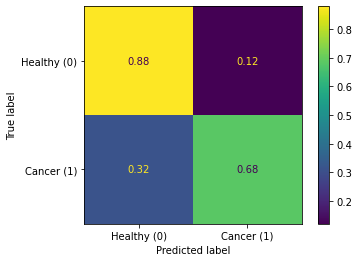

In [21]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True, save=True, filepath='data/plots/resnet50_cf_matrix.png')

In [14]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7360    0.8791    0.8012     16391
           1     0.8497    0.6844    0.7582     16377

    accuracy                         0.7818     32768
   macro avg     0.7929    0.7818    0.7797     32768
weighted avg     0.7929    0.7818    0.7797     32768



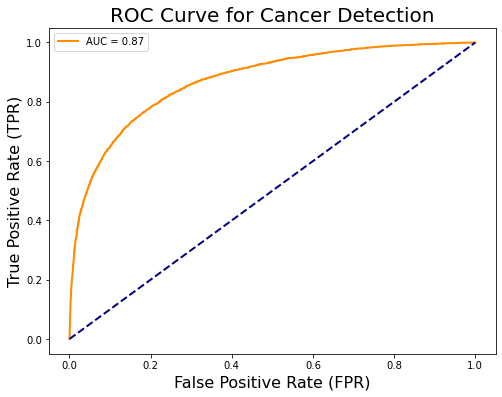

Area under curve (AUC):0.8723491197269666


In [22]:
pcamlib.plot_roc_curve(y_true, y_proba, save=True, filepath='data/plots/resnet50_roc.png')

ResNet50 achieved a test acccuracy of 78.2%, a positive class recall of 68.4%, and an AUC of 0.87.

Surprisingly, this model performed the worst overall. Because it's the deepest network, I expected it to outperform VGG16 but I think the extreme overfitting had a significant impact on its predictive ability. It still outperformed the pathologist benchmarks, however.

Much like VGG16, this model appears to favour predicting healthy tissue, correctly identifying around 88% of healthy tissue, but also misclassifying nearly 32% of cancer tissue as healthy.

Next, we'll see how much this model would reduce a pathologist's workload.

In [18]:
pcamlib.print_workload_reduction(y_pred)

59.7%


This model would theoretically reduce the pathologist's workload by 59.7%, however, but this metric is misleading. Similar to VGG16, the amount that these networks reduce the pathologist's workload not particularly meaningful when it misses so much cancer. 

|                     | Pathologist  | CNN1  | VGG16 | ResNet50 |
|---------------------|--------------|-------|-------|----------|
| AUC                 | 0.810 (mean) | 0.906 | 0.900 | 0.872    |
| Recall              | 62.8%        | 93.5% | 71.2% | 68.4%    |
| Test Accuracy       | --           | 78.7% | 80.5% | 78.2%    |
| Workload Reduced By | --           | 35.3% | 59.3% | 59.7%    |

Based on this summary table, CNN1 is by far the best performing model because it has the highest recall by a wide margin and the best AUC. The workload reduction is interesting to consider, but is misleading when evaluating the models against one another because models that misclassify a large number of cancer images reduce the workload significantly, but missing that much cancer tissue is extremely dangerous for the health and outcomes of the patients.

And finally, we can take a look at some of the misclassified images.

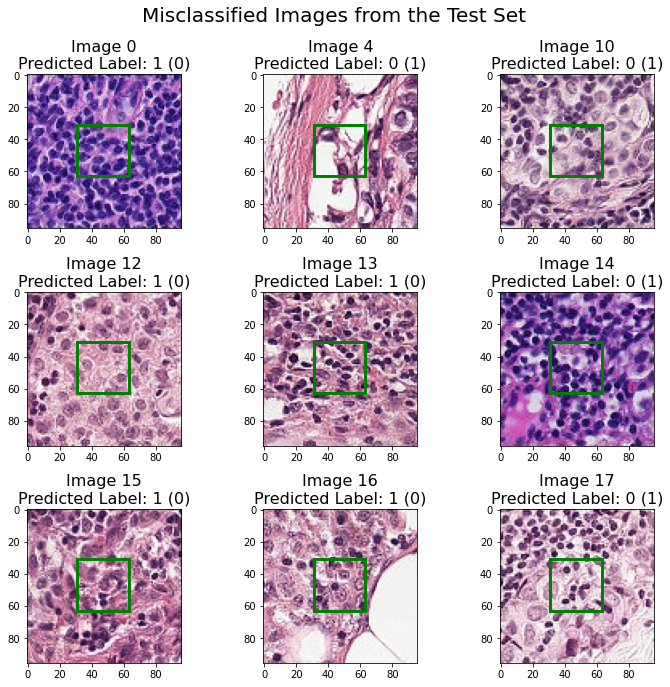

In [17]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

I have outlined my hypotheses for misclassified images in the notebook for CNN1. This model performed similarly to VGG16, and made many more incorrect predictions on the cancerous images. 

While it's hard to know for sure why the transfer learning models didn't perform as well as CNN1, the amount of overfitting likely played a large role in their poor performance. Also, because I imported the weights from the ImageNet dataset, and these images do not bear much resemblance to these histopathology slides, it's possible that these weights are not effective when classifying these types of images.

## 4.0 Next Steps

These are some of the possible next steps for this project:

1. Evaluate the models' performance on grayscale images

    The colour of these samples is due to the staining process and doesn't have any bearing on the class labelling, so it's possible that these CNNs may achieve similar accuracy on grayscaled versions of the images. Because grayscaled images only have 1 colour channel compared to the 3 channels in RGB images, the size of the dataset will be effectively reduced by 1/3, and the additional performance may be worth a small decrease in predictive ability.

2. Investigate which images are misclassified by all the models

    It's possible that some of the images in this dataset are inherently difficult to classify, because they may contain large amounts of white space or have other features that make them difficult to differentiate.
    
3. Extract the central 32x32 px region from the images

    I suspect part of the reason these models struggle with this classification task is that there is a large amount of tissue surrounding the central region of the image which doesn't contribute to the class label. These networks may be correctly identifying cancer which doesn't contribute to the label, and removing this unneeded information may help.
    
4. Visualize the CNN filters
    
    There is functionality within Keras to visualize some of the trained filters from the convolutional layers, and there may be insights gained from getting a broad understanding of what these filters are "looking for"